In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor_PM, MORCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def apply_overlap(y_train, overlap_ratio):
    N, D = y_train.shape
    indices = np.arange(N)

    # Number of shared (overlap) indices
    n_overlap = int(overlap_ratio * N)

    # Select overlap indices common to all output functions
    shared_indices = np.random.choice(indices, size=n_overlap, replace=False)

    # Initialize all to NaN
    y_obs = np.full_like(y_train, np.nan)

    # Set the shared overlap values
    y_obs[shared_indices, :] = y_train[shared_indices, :]

    # Remaining indices to distribute uniquely across each output
    remaining_indices = np.setdiff1d(indices, shared_indices)

    n_unique_per_output = (N - n_overlap) // D

    for d in range(D):
        # Randomly assign unique indices to each output from remaining pool
        if d < D - 1:
            chosen = np.random.choice(remaining_indices, size=n_unique_per_output, replace=False)
            remaining_indices = np.setdiff1d(remaining_indices, chosen)
        else:
            # Assign all remaining indices to the last output (in case of uneven division)
            chosen = remaining_indices
        y_obs[chosen, d] = y_train[chosen, d]

    return y_obs

## MOGP

[[1.       0.9     ]
 [0.9      1.000096]]


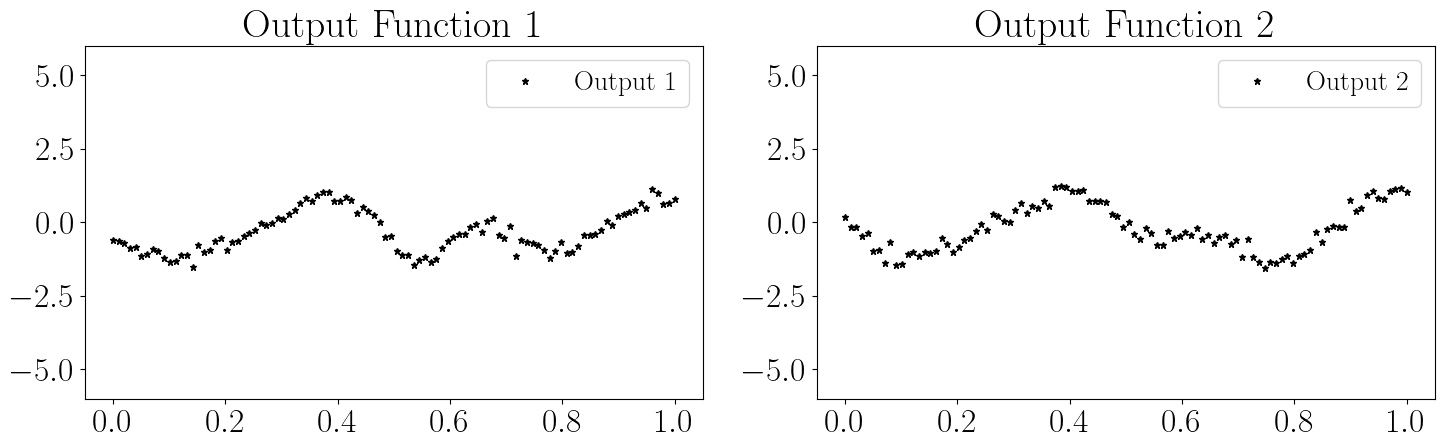

In [3]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 1

noise_variance = 0.04

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

# indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.30))[0]
# outlier_indices_025 = np.random.choice(indices_025, 1, replace=False)
# y_train[outlier_indices_025, 0] = -5

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

-40.0008637825408
-40.000863823017966
-40.000863640432144
-40.00086379640808
-40.00086377861077
-40.0008637668614
-40.00086377931116
8.290944770147686
8.290946012461411
8.290943560831925
8.290944697811433
8.290944788987112
8.290944668917632
8.29094469386714
-41.29168326074254
-41.29168326072284
-41.29168325608925
-41.291683279077745
-41.29168325530985
-41.291683247323874
-41.2916832603268
-41.34460698913917
-41.344606992955754
-41.344606993312325
-41.34460700157736
-41.34460698731493
-41.34460698117569
-41.34460698720266
-41.38049244775401
-41.38049242856454
-41.38049244938853
-41.38049245271801
-41.38049244626577
-41.380492451206
-41.38049245133129
-41.39618025376695
-41.39618025998638
-41.39618025339982
-41.39618025521838
-41.396180254306984
-41.39618025704502
-41.39618025469361
-41.398498164026634
-41.39849816598755
-41.398498163946655
-41.39849816603369
-41.398498164350656
-41.39849816735541
-41.39849816525107
-41.402391399463
-41.40239139668005
-41.402391399698644
-41.402391402109

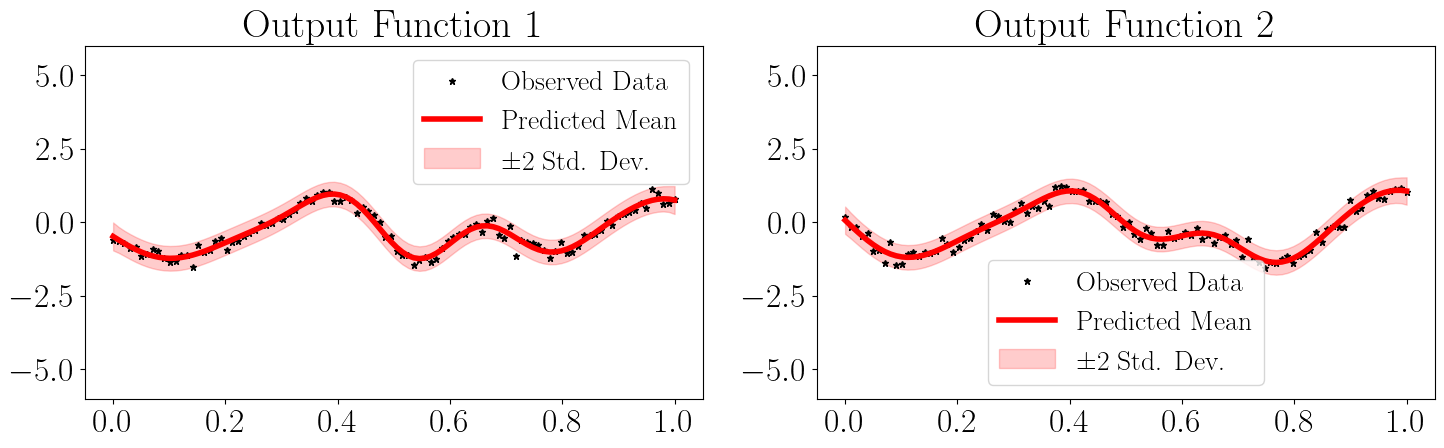

In [4]:
# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
# mogp.optimize_hyperparameters()
mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + noise_variance)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

## MORCGP - prior mean

[[1.       0.9     ]
 [0.9      1.000096]]


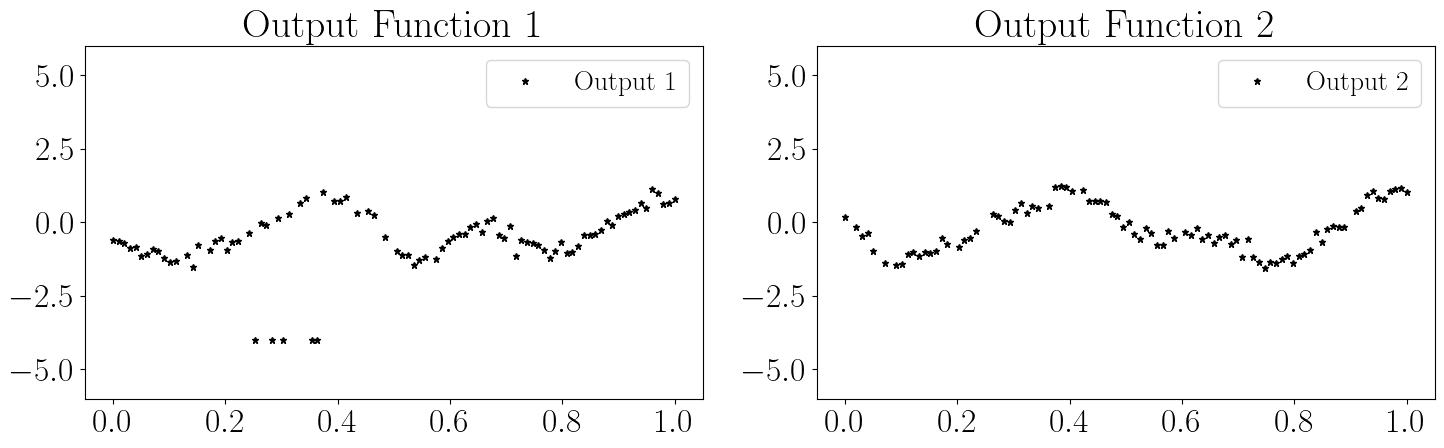

In [7]:
np.random.seed(42)

# Initialisation
constant_mean = 0
epsilon = 0.05
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.8

noise_variance = 0.04

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.40))[0]
outlier_indices_025 = np.random.choice(indices_025, int(epsilon * n_points), replace=False)
y_train[outlier_indices_025, 0] = -4

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [8]:
# Instantiate and train
morcgp = MORCGPRegressor_PM(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A, epsilon = epsilon)
morcgp.fit(x_train, y_train)

# # Optimize hyperparameters
# mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

AttributeError: 'int' object has no attribute 'reshape'

## MORCGP - cross channel predictive

[[1.999396 1.200486]
 [1.200486 1.000642]]


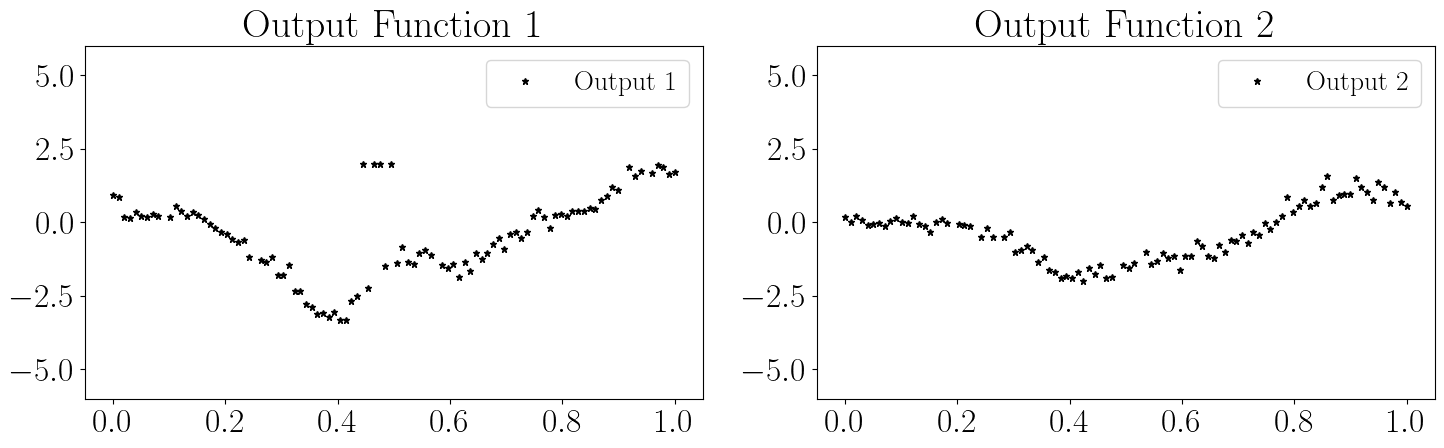

In [3]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

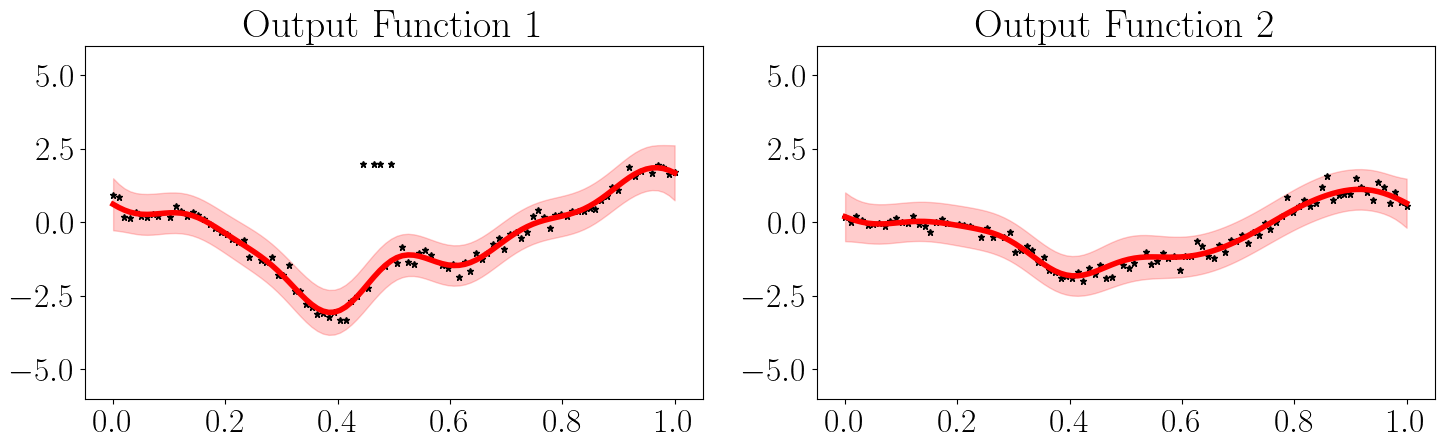

In [8]:
# Instantiate and train
morcgp = MORCGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# # Optimize hyperparameters
# mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - predictive_variances[:, i], predictive_mean[:, i] + predictive_variances[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()